In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

In [89]:
LAT_START = 31.52
LON_START = -125.48
LAT_END = 43.0
LON_END = -113.131
GRID_SPACING = 0.1

num_contour_levels = 50

In [90]:
data = pd.read_csv('../data/NOAA_weather_data/2015_california_box_all.csv') 
data.head()

,time,lat,lon,air.sfc,air.2m,apcp,crain,rhum.2m,dpt.2m,pres.sfc,uwnd.10m,vwnd.10m,veg
0,2015-01-01 00:00:00,31.63322,-125.3449,291.3521,288.57355,0.0,0.0,72.27641,283.55856,102185.5,2.868942,-9.560348,NaN
1,2015-01-01 00:00:00,31.90358,-125.4247,291.3521,288.57355,0.0,0.0,72.27641,283.55856,102185.5,2.915817,-9.896286,NaN
2,2015-01-01 00:00:00,31.70029,-125.0272,291.3521,288.51105,0.0,0.0,71.40141,283.33980,102185.5,3.095505,-9.474411,NaN
3,2015-01-01 00:00:00,31.97103,-125.1057,291.2271,288.44855,0.0,0.0,71.33891,283.23044,102185.5,3.118942,-9.771286,NaN
4,2015-01-01 00:00:00,32.24205,-125.1849,291.0396,288.26105,0.0,0.0,70.90141,282.98825,102085.5,3.158005,-9.779098,NaN


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4058800 entries, 0 to 4058799
Data columns (total 13 columns):
time        object
lat         float64
lon         float64
air.sfc     float64
air.2m      float64
apcp        float64
crain       float64
rhum.2m     float64
dpt.2m      float64
pres.sfc    float64
uwnd.10m    float64
vwnd.10m    float64
veg         float64
dtypes: float64(12), object(1)
memory usage: 402.6+ MB


In [92]:
data_one_hour = data[data['time'] == '2015-03-23 18:00:00']
data_one_hour.head()

,time,lat,lon,air.sfc,air.2m,apcp,crain,rhum.2m,dpt.2m,pres.sfc,uwnd.10m,vwnd.10m,veg
909060,2015-03-23 18:00:00,31.63322,-125.3449,290.23242,288.93454,0.0,0.0,80.32931,285.51624,103069.41,2.120010,-5.984589,NaN
909061,2015-03-23 18:00:00,31.90358,-125.4247,290.23242,288.93454,0.0,0.0,80.32931,285.51624,103069.41,2.620010,-5.953339,NaN
909062,2015-03-23 18:00:00,31.70029,-125.0272,290.23242,288.99704,0.0,0.0,80.82931,285.64905,103069.41,2.541885,-5.898651,NaN
909063,2015-03-23 18:00:00,31.97103,-125.1057,290.04492,288.87204,0.0,0.0,80.57931,285.44592,103069.41,3.065323,-5.883026,NaN
909064,2015-03-23 18:00:00,32.24205,-125.1849,289.91992,288.80954,0.0,0.0,80.51681,285.37560,103069.41,3.596573,-5.773651,NaN


In [93]:
data_one_hour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1390 entries, 909060 to 910449
Data columns (total 13 columns):
time        1390 non-null object
lat         1390 non-null float64
lon         1390 non-null float64
air.sfc     1390 non-null float64
air.2m      1390 non-null float64
apcp        1390 non-null float64
crain       1390 non-null float64
rhum.2m     1390 non-null float64
dpt.2m      1390 non-null float64
pres.sfc    1390 non-null float64
uwnd.10m    1390 non-null float64
vwnd.10m    1390 non-null float64
veg         927 non-null float64
dtypes: float64(12), object(1)
memory usage: 152.0+ KB


In [102]:
def regularize_grid(data, data_type):
    data = data.dropna()
    
    # data coordinates and values
    x = data['lon']
    y = data['lat']
    z = data[data_type]

    # target grid to interpolate to
    xi = np.arange(LON_START,LON_END,GRID_SPACING)
    yi = np.arange(LAT_START,LAT_END,GRID_SPACING)
    xi,yi = np.meshgrid(xi,yi)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='linear')
    
    return xi, yi, zi

In [127]:
data_type = 'uwnd.10m'
xi, yi, zi = regularize_grid(data_one_hour, data_type)

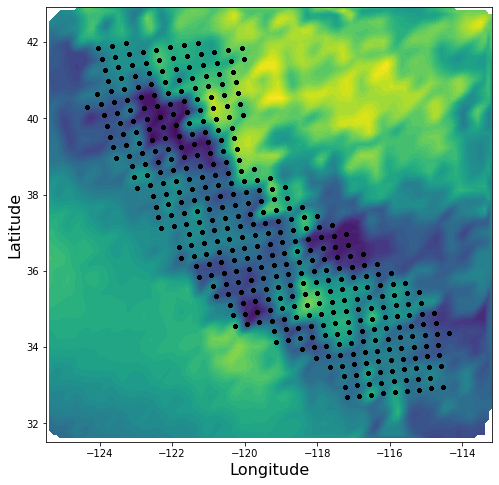

In [128]:
# plot
plt.rcParams["figure.figsize"] = (8,8)
plt.contourf(xi, yi, zi, num_contour_levels)
plt.plot(x, y, 'k.')
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.show()

In [129]:
import geopandas as gpd
from geopandas import GeoSeries
import contextily as ctx
from pyproj import Proj, transform

In [130]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')
x2, y2 = transform(inProj, outProj, xi, yi)

<Figure size 576x576 with 0 Axes>

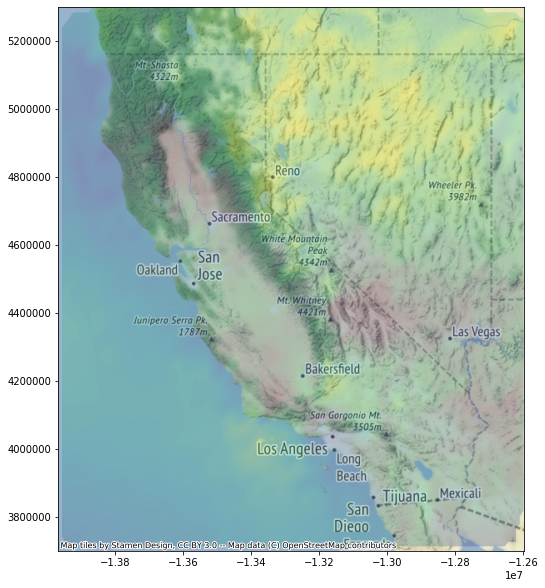

In [131]:
gdf = gpd.read_file('../data/spatial_data/cb_2018_us_state_500k.shp')
california = gdf[gdf['NAME'] == 'California']
california_3857 = california.to_crs(epsg=3857)

plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure() 
ax = california_3857.plot(figsize=(10, 10), alpha=0.0, edgecolor='k')
ax.contourf(x2, y2, zi, num_contour_levels, alpha=0.3, antialiased=True)
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=6)

In [132]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch

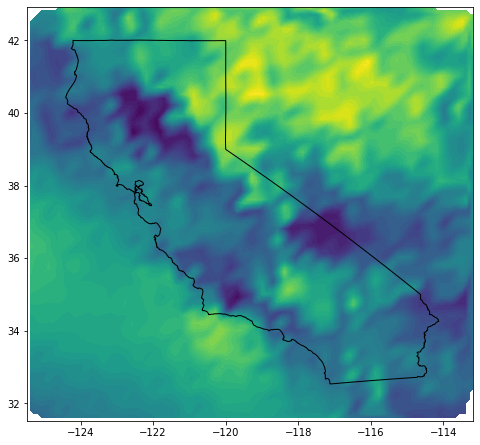

In [133]:
multipoly = california.loc[16, 'geometry']
california_land_mass = multipoly[-1]

plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure() 
ax = fig.gca() 
ax.add_patch(PolygonPatch(california_land_mass, fc='none', ec='black', zorder=2))
ax.contourf(xi, yi, zi, num_contour_levels)
ax.axis('scaled')
plt.show()